# AdventureWorks Analysis - IN PROGRESS
From EdX Microsoft DAT 275x course, "Principles of Machine Learning: Python Edition"
## 3. Linear Regression 

### The linear regression model will predict customers' average monthly spend. 

In [1]:
#Load required packages 

import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math

%matplotlib inline

In [2]:
#Import working file from 1_AW_Data_Prep.ipynb

df_1 = pd.read_csv('working_df.csv')
print(df_1.shape)
df_1.head()

(16471, 13)


,BikeBuyer,Country,Education,Occupation,Gender,MaritalStatus,Home,AveMoSpend,Income,BirthYear,Cars,Child_Home,Child_Total
0,0,Australia,Bachelors,Professional,M,M,1,89,137947,1966,0,0,2
1,1,Australia,Bachelors,Professional,M,S,0,117,101141,1965,1,3,3
2,0,Australia,Bachelors,Professional,M,M,1,123,91945,1965,1,3,3
3,0,Australia,Bachelors,Professional,F,S,0,50,86688,1968,1,0,0
4,1,Australia,Bachelors,Professional,F,S,1,95,92771,1968,4,5,5


### Feature Selection 

The following features are selected to include in the linear regression model based on the work completed in the second workbook on exploratory data analysis and visualizations, "2_AW_EDA and Visualization": 

* Numeric: 
    * Child_Home 
    * Income 
* Categorical: 
    * BikeBuyer
    * Occupation 
    * Gender
    * MaritalStatus

Load file and select features that will be used in the regression model.


In [3]:
#Remove excess columns and re-order with label first 

df_2 = df_1.iloc[:,[7,11,8,0,3,4,5]].copy()
df_2.head()

,AveMoSpend,Child_Home,Income,BikeBuyer,Occupation,Gender,MaritalStatus
0,89,0,137947,0,Professional,M,M
1,117,3,101141,1,Professional,M,S
2,123,3,91945,0,Professional,M,M
3,50,0,86688,0,Professional,F,S
4,95,5,92771,1,Professional,F,S


### Data Transformation

Create a column with the log of AveMoSpend ('Log_AveMoSpend') and compare its distribution to AveMoSpend in an effort to normalize the distribution. The distribution of Log_AveMoSpend does appear more normal and will therefore be used as the label. 

In [4]:
#Create a new variable that is the log of AveMoSpend and rename "Log_AveMoSpend"

df_2['Log_AveMoSpend'] = np.log(df_2['AveMoSpend'])
df_2.head()

,AveMoSpend,Child_Home,Income,BikeBuyer,Occupation,Gender,MaritalStatus,Log_AveMoSpend
0,89,0,137947,0,Professional,M,M,4.488636
1,117,3,101141,1,Professional,M,S,4.762174
2,123,3,91945,0,Professional,M,M,4.812184
3,50,0,86688,0,Professional,F,S,3.912023
4,95,5,92771,1,Professional,F,S,4.553877


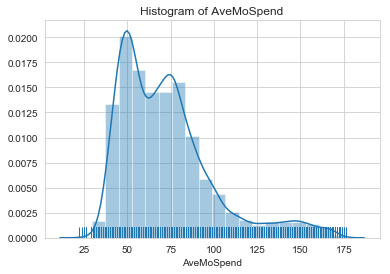

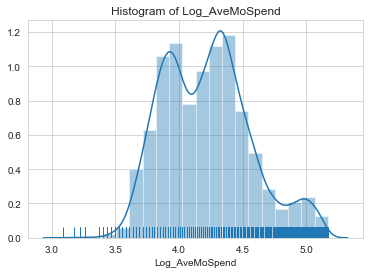

In [5]:
#Combined histograms and kdes of AveMoSpend and Log_AveMoSpend

def plot_density_hist(df_2, cols, bins = 20, hist = True):
    for col in cols:
        sns.set_style("whitegrid")
        sns.distplot(df_2[col], bins = bins, rug = True, hist = hist)
        plt.title('Histogram of ' + col) # Give the plot a main title
        plt.xlabel(col) # Set text for the x axis
        plt.show()
 
num_cols = ['AveMoSpend','Log_AveMoSpend']    
plot_density_hist(df_2, num_cols, bins = 20, hist = True) 

### Check for Outliers

Check for outliers. The maximum and minimum observations for numeric features are less than +/- three standard deviations from the mean. This seems reasonable and I will therefore not remove any data points. 

In [6]:
#Check for outliers 

df_2.describe().round(1)

,AveMoSpend,Child_Home,Income,BikeBuyer,Log_AveMoSpend
count,16471.0,16471.0,16471.0,16471.0,16471.0
mean,72.4,1.0,78157.3,0.3,4.2
std,27.3,1.5,39708.9,0.5,0.3
min,22.0,0.0,9482.0,0.0,3.1
25%,52.0,0.0,47842.0,0.0,4.0
50%,68.0,0.0,76146.0,0.0,4.2
75%,84.0,2.0,105202.0,1.0,4.4
max,176.0,5.0,196511.0,1.0,5.2


### Data Preparation 

Combine categories within Occupation that have overlapping or similar distributions of label values: 

* Combine Professional and Management and rename 'Prof_Mgmt', and 
* Combine Skilled Manual, Clerical, and Manual and rename 'Manual_Clerical'.

Transform categorical variables to dummy variables. In this case all categorical variables have only two categories. 


In [7]:
# Convert 'Occupation' categories to new combined categories and convert all categorical variables to dummy variables.

code_list = [['Occupation', 
            {'Clerical' : 'Manual_Clerical',
             'Management' : 'Prof_Mgmt', 
             'Manual' : 'Manual_Clerical', 
             'Professional' : 'Prof_Mgmt', 
             'Skilled Manual' : 'Manual_Clerical'}]]

for col_dic in code_list:
    col = col_dic[0]
    dic = col_dic[1]
    df_2[col] = [dic[x] for x in df_2[col]]
    
df_2.head()

,AveMoSpend,Child_Home,Income,BikeBuyer,Occupation,Gender,MaritalStatus,Log_AveMoSpend
0,89,0,137947,0,Prof_Mgmt,M,M,4.488636
1,117,3,101141,1,Prof_Mgmt,M,S,4.762174
2,123,3,91945,0,Prof_Mgmt,M,M,4.812184
3,50,0,86688,0,Prof_Mgmt,F,S,3.912023
4,95,5,92771,1,Prof_Mgmt,F,S,4.553877


### Prepare Model Matrix 

All scikit-learn models require a numpy array containing numeric values only for the features. This matrix is called a model matrix. Two steps are required to create the model matrix:

* categorical variables must be converted to dummy variables (already done), and
* numeric features must be rescaled.

In [8]:
#Encode first categorical variable as numbers

print(df_2['BikeBuyer'].unique())
Features = df_2['BikeBuyer']
enc = preprocessing.LabelEncoder()
enc.fit(Features)
Features = enc.transform(Features)
print(Features)

[0 1]
[0 1 0 ... 1 0 0]


In [9]:
#Encode the numbers to a dummy variable

ohe = preprocessing.OneHotEncoder(categories = 'auto')
encoded = ohe.fit(Features.reshape(-1,1))
Features = encoded.transform(Features.reshape(-1,1)).toarray()
Features[:10,:]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [10]:
#Add all remaining categorical variables 

def encode_string(cat_feature):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_feature)
    enc_cat_feature = enc.transform(cat_feature)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder(categories = 'auto')
    encoded = ohe.fit(enc_cat_feature.reshape(-1,1))
    return encoded.transform(enc_cat_feature.reshape(-1,1)).toarray()
    

categorical_columns = ['Occupation','Gender','MaritalStatus']

for col in categorical_columns:
    temp = encode_string(df_2[col])
    Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :])  

(16471, 8)
[[1. 0. 0. 1. 0. 1. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]]


In [11]:
#Add numeric features to complete the model matrix 

Features = np.concatenate([Features, np.array(df_2[['Child_Home','Income']])], axis = 1)
Features[:5,:].round(2)

array([[1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.37947e+05],
       [0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 3.00000e+00, 1.01141e+05],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 3.00000e+00, 9.19450e+04],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 8.66880e+04],
       [0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 5.00000e+00, 9.27710e+04]])

In [12]:
#Check that there are the proper number of columns (one column for each unique category of all categorical variables)

Features.shape

(16471, 10)

### Split the dataset

In [13]:
#Create randomly sampled training and test data sets using Bernoulli sampling. The test set is 3000 (18.2% of sample).

nr.seed(9988)
labels = np.array(df_2['Log_AveMoSpend'])
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 3000)
x_train = Features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(labels[indx[1]])

### Rescale numeric features 

Rescale numeric features using z-scores so that they have a similar range of values. This prevents features with a larger range a disproportionate impact on the model. Note that the scaler is fit only on the training data. 

In [14]:
scaler = preprocessing.StandardScaler().fit(x_train[:,(0,1)])
x_train[:,(0,1)] = scaler.transform(x_train[:,(0,1)])
x_test[:,(0,1)] = scaler.transform(x_test[:,(0,1)])
print(x_train.shape)
x_train[:5,:].round(2)

(13471, 10)


array([[-1.41000e+00,  1.41000e+00,  0.00000e+00,  1.00000e+00,
         0.00000e+00,  1.00000e+00,  1.00000e+00,  0.00000e+00,
         5.00000e+00,  1.56831e+05],
       [ 7.10000e-01, -7.10000e-01,  1.00000e+00,  0.00000e+00,
         0.00000e+00,  1.00000e+00,  1.00000e+00,  0.00000e+00,
         0.00000e+00,  2.27360e+04],
       [ 7.10000e-01, -7.10000e-01,  0.00000e+00,  1.00000e+00,
         1.00000e+00,  0.00000e+00,  0.00000e+00,  1.00000e+00,
         2.00000e+00,  7.83100e+04],
       [ 7.10000e-01, -7.10000e-01,  1.00000e+00,  0.00000e+00,
         0.00000e+00,  1.00000e+00,  0.00000e+00,  1.00000e+00,
         0.00000e+00,  1.64810e+04],
       [-1.41000e+00,  1.41000e+00,  0.00000e+00,  1.00000e+00,
         0.00000e+00,  1.00000e+00,  1.00000e+00,  0.00000e+00,
         3.00000e+00,  1.41307e+05]])

### Linear regression model

Note that no intercept is fit in this model. This is because its value is accommodated in the dummy variables' coefficients that were created for the categorical features.

The coefficients correspond to the following variables in order.  Note that the first eight coefficients correspond with the four dummy, or categorical, variables. 

1. BikeBuyer = 0: Customer does not buy a bike
2. BikeBuyer = 1: Customer buys bike
3. Occupation = 0: Manual_Clerical: customer has a manual, skilled manual, or clerical occupation 
4. Occupation = 1: Prof_Mgmt: customer has a professional or management occupation 
5. Gender = 0: Female
6. Gender = 1: Male
7. MaritalStatus = 0: Married  
8. MaritalStatus = 1: Single
9. Child_Home = Scaled z-score of number of children at home 
10. Income = Scaled z-score of annual income 


In [15]:
#Define and fit the linear regression model.
lin_mod = linear_model.LinearRegression(fit_intercept = False)
lin_mod.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)

In [16]:
print(lin_mod.intercept_)
print(lin_mod.coef_)

0.0
[-5.33701751e-03  5.33701754e-03  1.30105087e+00  1.29081339e+00
  1.09942588e+00  1.49243838e+00  1.33876955e+00  1.25309471e+00
  1.26884390e-01  2.56532550e-06]


### Evaluate model 



In [17]:
#Basic metrics 

def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
y_score = lin_mod.predict(x_test) 
print_metrics(y_test, y_score, 28)    

Mean Square Error      = 0.004748964872469868
Root Mean Square Error = 0.06891273374689084
Mean Absolute Error    = 0.052528538767375475
Median Absolute Error  = 0.042863496041332105
R^2                    = 0.9596930978389051
Adjusted R^2           = 0.9593269180413447


In [17]:
#Basic metrics 

def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
y_score = lin_mod.predict(x_test) 
print_metrics(y_test, y_score, 28)    

Mean Square Error      = 0.004748964872469868
Root Mean Square Error = 0.06891273374689084
Mean Absolute Error    = 0.052528538767375475
Median Absolute Error  = 0.042863496041332105
R^2                    = 0.9596930978389051
Adjusted R^2           = 0.9593269180413447


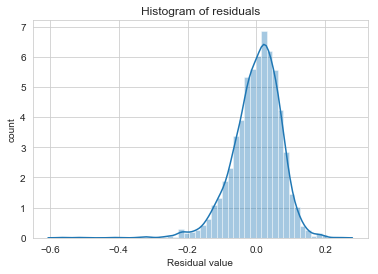

In [18]:
# Display a histogram of the residuals

def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y_test, y_score)    

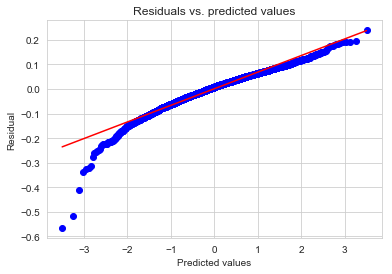

In [19]:
# Display Q-Q Normal Plot

def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    
resid_qq(y_test, y_score)   

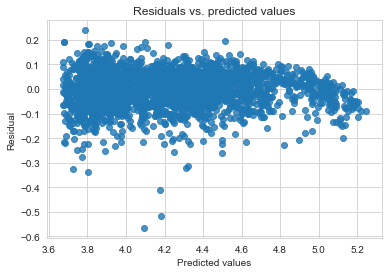

In [20]:
# Residuals versus predicted 

def resid_plot(y_test, y_score,):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')

resid_plot(y_test, y_score) 

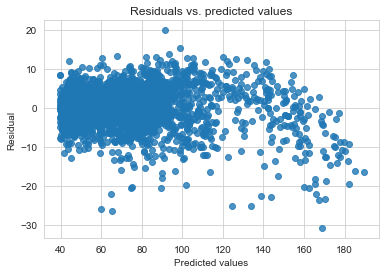

In [21]:
#The prior residual plot was for the log of AveMoSpend. Create another but transforme to real prices 

y_score_untransform = np.exp(y_score)
y_test_untransform = np.exp(y_test)
resid_plot(y_test_untransform, y_score_untransform) 